In [1]:
import os
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_filtering as depth_filtering
from sklearn.linear_model import RANSACRegressor

DATAFILE = "/scratchdata/far"

In [2]:
# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

In [3]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/depth/points"]):
    wait += 1
    if wait == 6:
        print(len(msg.data))
        pc_raw = np.frombuffer(msg.data, dtype=np.uint8)
        print(pc_raw)
        print(msg.fields)
        

3783104
[205  59 172 ...  64 254 191]
[name: "x"
offset: 0
datatype: 7
count: 1, name: "y"
offset: 4
datatype: 7
count: 1, name: "z"
offset: 8
datatype: 7
count: 1]


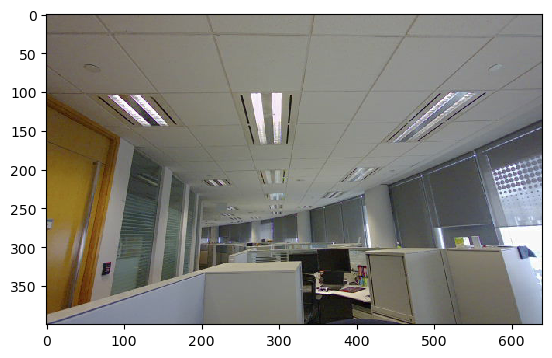

In [4]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    wait += 1
    if wait == 5:
        img = data_conversion.topic_to_image(msg)
        break

plt.imshow(img)
plt.imsave(os.path.join(DATAFILE, "color.png"), img)

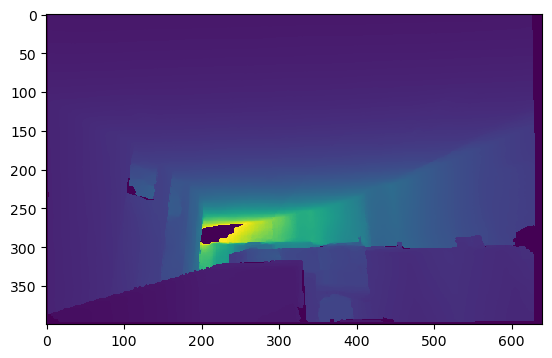

In [5]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    wait += 1
    if wait == 5:
        depth = data_conversion.topic_to_depth(msg)
        break

plt.imshow(depth)

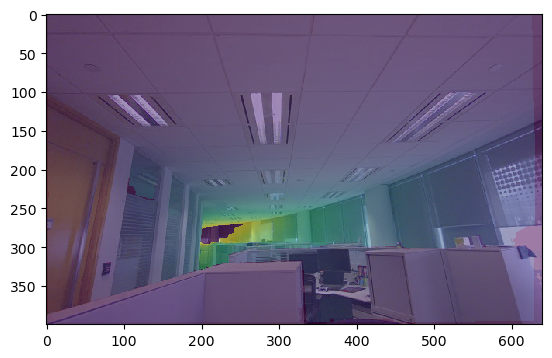

In [6]:
# Overlay image overdepth at half alpha
plt.imshow(depth)
plt.imshow(img, alpha=0.5)

/Depth-Anything-V2


xFormers not available
xFormers not available
/tmp/ipykernel_16496/3502881802.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/scratc

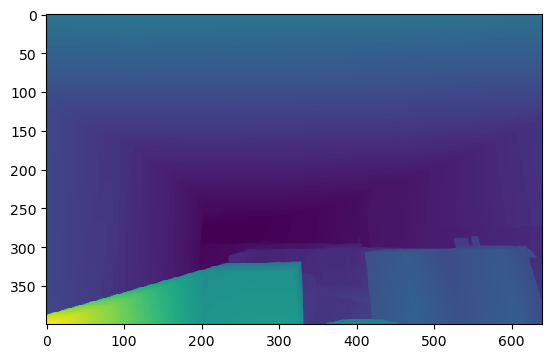

In [7]:
import os
os.chdir("/Depth-Anything-V2")
print(os.getcwd())

import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/scratchdata/depth_anything_v2_vitl.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

est_depth = model.infer_image(np.array(img)) # HxW raw depth map in numpy
plt.imshow(est_depth)

In [12]:
print(est_depth[0,0])
print(est_depth[-1,0])

352.25894
874.16376


In [8]:
import json

with open(os.path.join(DATAFILE,"masks.json"),"r") as f:
    masks = json.load(f)
    

(117743, 1)
Percentage of inliers:  0.8496216335578336
(18017, 1)
Percentage of inliers:  0.973469501026808
(9209, 1)
Percentage of inliers:  0.913454229558041
(7057, 1)
Percentage of inliers:  0.7894289358084172
(7687, 1)
Percentage of inliers:  0.8670482633016782
(16942, 1)
Percentage of inliers:  0.7821390626844529
(9368, 1)
Percentage of inliers:  0.8273911187019641
(739, 1)
Percentage of inliers:  1.0
(692, 1)
Percentage of inliers:  0.7239884393063584
(9510, 1)
Percentage of inliers:  0.8093585699263933
(2546, 1)
Percentage of inliers:  0.8228593872741555
(664, 1)
Percentage of inliers:  0.5903614457831325
(1487, 1)
Percentage of inliers:  1.0
(1159, 1)
Percentage of inliers:  0.8981880931837791
(3040, 1)
Percentage of inliers:  1.0
(2937, 1)
Percentage of inliers:  1.0
(522, 1)
Percentage of inliers:  1.0
(3050, 1)
Percentage of inliers:  1.0
(7275, 1)
Percentage of inliers:  1.0
(754, 1)
Percentage of inliers:  1.0
(2937, 1)
Percentage of inliers:  1.0
(6315, 1)
Percentage of i

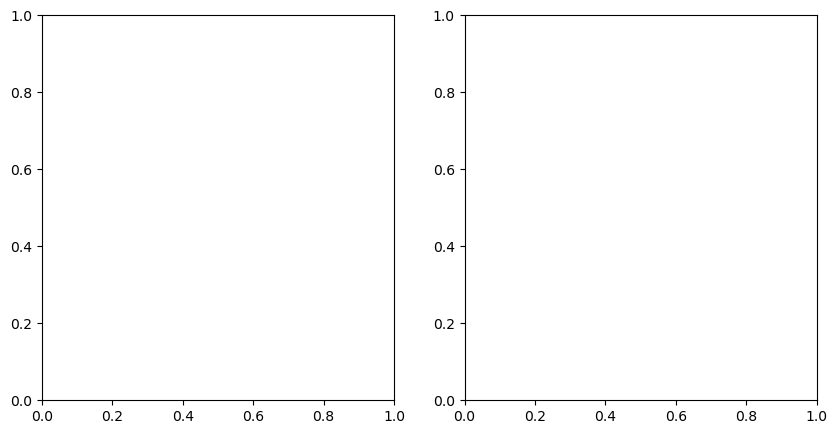

In [13]:
#Subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

all_corrected_depth = depth.copy()

POLYNOMIAL_ORDER = 1

for mask in masks["sam"]:
    #if mask["area"] < 2000: continue
    mask = mask["segmentation"]
    mask = np.array(mask)
    
    #Select the depth and est_depth values that corresponds to the mask
    selected_depth = np.zeros_like(depth)
    selected_est_depth = np.zeros_like(est_depth)
    
    selected_depth[mask==1] = depth[mask==1]
    selected_est_depth[mask==1] = est_depth[mask==1]
    
    axs[0].imshow(selected_depth)
    #axs[0].imshow(selected_est_depth, alpha=0.5)
    
    #Plot scatter plot of the depth vs est_depth
    normalised_selected_depth = depth_filtering.normalise(selected_depth)
    normalsised_selected_est_depth = depth_filtering.normalise(selected_est_depth)
    normalsised_selected_est_depth = 1 - normalsised_selected_est_depth
    #axs[1].scatter(normalised_selected_depth, normalsised_selected_est_depth)
    
    #Use RANSAC to find the best fit line
    ransac = RANSACRegressor(max_trials=10000,)

    print(selected_est_depth[selected_depth!=0].reshape(-1,1).shape)
    if (selected_depth[selected_depth!=0].reshape(-1,1).shape[0]==0): continue
    
    ransac.fit(selected_est_depth[selected_depth!=0].reshape(-1,1), selected_depth[selected_depth!=0].reshape(-1,1))
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    # Show ratio of inliers/outliers
    #print(f"RANSAC: {sum(inlier_mask)}/{len(inlier_mask)} inliers")
    print("Percentage of inliers: ", sum(inlier_mask)/len(inlier_mask))
    
    if (sum(inlier_mask)/len(inlier_mask) < 0.5): continue
    
    # Get the best fit line
    corrected_depth = selected_est_depth * ransac.estimator_.coef_ + ransac.estimator_.intercept_
    visualise = np.zeros_like(selected_depth)
    visualise[mask==1] = corrected_depth[mask==1]
    axs[1].imshow(visualise)
    
    all_corrected_depth[mask==1] = corrected_depth[mask==1]

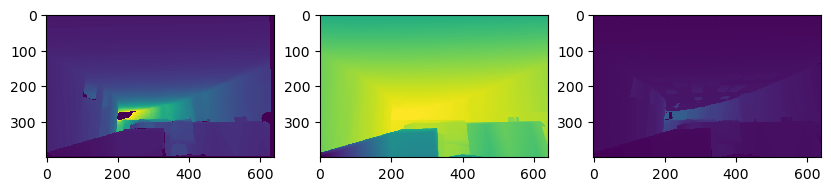

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


axs[0].imshow(depth_filtering.normalise(depth))
axs[1].imshow(depth_filtering.normalise(-est_depth))
axs[2].imshow(depth_filtering.normalise(all_corrected_depth))

plt.show()

In [11]:
print(depth_filtering.normalise(depth)[0,0])
print(depth_filtering.normalise(all_corrected_depth)[0,0])


0.0
0.01977927914157317
